# Environment Setup

In [10]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q timm
#!pip install -q roboflow
!pip install wandb
!pip install albumentations


Looking in indexes: https://test.pypi.org/simple/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 42.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 49.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 26.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 22.5 MB/s eta 0:00:00


In [1]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

#import roboflow
import supervision
import transformers
import pytorch_lightning

print(
#    "roboflow:", roboflow.__version__, 
    "; supervision:", supervision.__version__, 
    "; transformers:", transformers.__version__, 
    "; pytorch_lightning:", pytorch_lightning.__version__
)
     

/bin/bash: line 1: nvcc: command not found
torch:  2.1 ; cuda:  2.1.2
; supervision: 0.3.0 ; transformers: 4.36.1 ; pytorch_lightning: 2.1.2


# Load Model

In [2]:
# Huggingface 모델 라이브러리에서 pretrained image_processor & model 불러오기
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'


image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a Ber

# Create COCO data loaders

In [4]:
import os
import torchvision


# settings
dataset_location = f"/mnt/d/Data/final/dataset"
ANNOTATION_FILE_NAME = "labels.json"
TRAIN_DIRECTORY = os.path.join(dataset_location, "train")
VAL_DIRECTORY = os.path.join(dataset_location, "val")
TEST_DIRECTORY = os.path.join(dataset_location, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        dataset_directory_path: str,    # lables.json 파일 data폴더 외부에 존재할 경우 사용
        image_directory_path: str,  # lables.json 파일 data폴더 내부에 존재할 경우 사용
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME) # labels.json 파일 디렉토리
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target # pixel_values: image_processor에서 처리한 이미지 결과, target: image_processor에서 처리한 라벨 결과


TRAIN_DATASET = CocoDetection(
    dataset_directory_path=f"{TRAIN_DIRECTORY}",
    image_directory_path=f"{TRAIN_DIRECTORY}//data",
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    dataset_directory_path=f"{VAL_DIRECTORY}",
    image_directory_path=f"{VAL_DIRECTORY}//data",
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    dataset_directory_path=f"{TEST_DIRECTORY}",
    image_directory_path=f"{TEST_DIRECTORY}//data",
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
Number of training examples: 23323
Number of validation examples: 10654
Number of test examples: 3901


# Visualize Data Entry

Image #11477


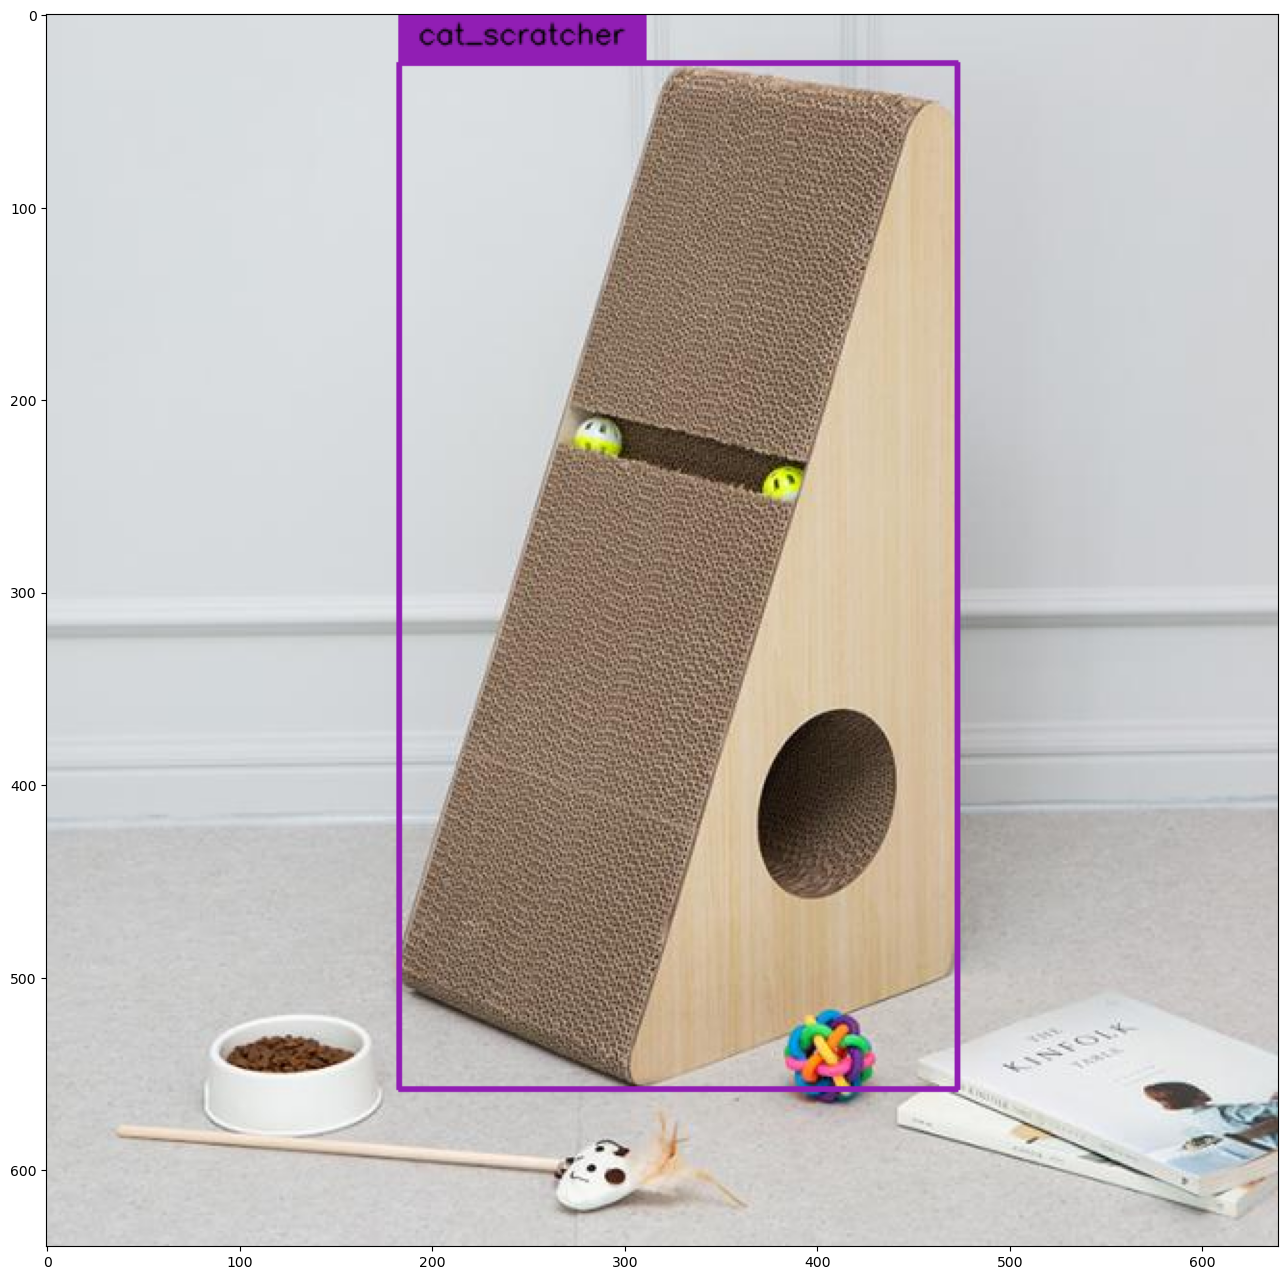

In [5]:
import random
import cv2
import numpy as np
import supervision as sv


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()} # 카테고리 번호와 카테고리 이름을 딕셔너리 형태로 저장

labels = [  # annotation의 카테고리 이름 저장
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.show_frame_in_notebook(image, (16, 16))

In [6]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR 논문에서 훈련 중 다양한 이미지 크기를 사용했기 때문에 직접 배치를 구성할 수 없음. 
    # 가장 큰 해상도(min:800, max: 1333)로 이미지를 패딩하고 실제 픽셀과 패딩 픽셀을 구분하는 이진 pixel_mask를 생성.
 
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, num_workers=8, shuffle=True, pin_memory=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4, num_workers=8, pin_memory=True)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=2, pin_memory=True)

# Train Model with Pytorch Lightning

In [7]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection, DetrForObjectDetection
import torch
import wandb



class Detr(pl.LightningModule):

    def __init__(self, lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(    # huggingface 모델 라이브러리에서 pretrained 모델 불러오기
            pretrained_model_name_or_path=CHECKPOINT,
            revision = 'no_timm',
            num_labels=len(id2label),   # 인식할 카테고리 갯수
            ignore_mismatched_sizes=True    # pretrained 된 모델과 사이즈가 달라도 오류 무시
        )
        
        self.save_hyperparameters
        
        # 특정 레이어 Freeze
            # backbone
        for param in self.model.model.backbone.parameters():
            param.requires_grad = False

            # attention heads
        for layer in self.model.model.encoder.layers:   # encoder의 self-attention-heads
            for param in layer.self_attn.parameters():
                param.requires_grad = False

        for layer in self.model.model.decoder.layers:   # decoder의 self-attention-heads & encoder-attention-heads
            for param in layer.self_attn.parameters():
                param.requires_grad = False
            for param in layer.encoder_attn.parameters():
                param.requires_grad = False

            # Encoder와 Decoder의 각 초반 3개 layers
        # for layer in self.model.model.encoder.layers[:3]: # First 3 layers of encoder
        #     for param in layer.parameters():
        #         param.requires_grad = False
        
        # for layer in self.model.model.decoder.layers[:3]: # First 3 layers of decoder
        #     for param in layer.parameters():
        #         param.requires_grad = False

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # train, validation, test loss 계산에 공통적으로 필요한 처리 
    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict
  
        return loss, loss_dict

        # training loss 계산
    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss, on_step=True, on_epoch=True, logger=True)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())
        return loss
        
        # validation loss 계산
    def validation_step(self, batch, batch_idx):    
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss,on_step=True, on_epoch=True, logger=True)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
        return loss

    def test_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("test_loss", loss, on_step=True, on_epoch=True, logger=True)
        for k,v in loss_dict.items():
            self.log("test_" + k, v.item())
        return loss

    def configure_optimizers(self):
        # DETR 논문에서 backbone과 나머지 layer에 다른 학습률을 사용한 것을 코드로 구현 (공부목적)
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},  # backbone 아닌경우 learning rate = lr
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],   # backbone일 경우 learning rate = lr_backbone
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

    def test_dataloader(self):
        return TEST_DATALOADER

**Start WanDB Logger**

In [8]:
from pytorch_lightning.loggers import WandbLogger
# Weights and Biases Logger 설정
wandb_logger = WandbLogger(name="run7 - 30epochs", project="YouReco-DeTR", save_dir="/mnt/c/Users/jhk16/PycharmProjects/Wise_Ad-/personal/JinhyunKim/Detection/YouReco_DeTR", log_model=True)

In [9]:
# 학습할 모델 설정
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

# Layer Freeze 확인
for name, param in model.model.model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

# 모델 GPU에 로드
model.to(DEVICE)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([11, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([11]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


backbone.conv_encoder.model.embedder.embedder.convolution.weight: requires_grad=False
backbone.conv_encoder.model.encoder.stages.0.layers.0.shortcut.convolution.weight: requires_grad=False
backbone.conv_encoder.model.encoder.stages.0.layers.0.layer.0.convolution.weight: requires_grad=False
backbone.conv_encoder.model.encoder.stages.0.layers.0.layer.1.convolution.weight: requires_grad=False
backbone.conv_encoder.model.encoder.stages.0.layers.0.layer.2.convolution.weight: requires_grad=False
backbone.conv_encoder.model.encoder.stages.0.layers.1.layer.0.convolution.weight: requires_grad=False
backbone.conv_encoder.model.encoder.stages.0.layers.1.layer.1.convolution.weight: requires_grad=False
backbone.conv_encoder.model.encoder.stages.0.layers.1.layer.2.convolution.weight: requires_grad=False
backbone.conv_encoder.model.encoder.stages.0.layers.2.layer.0.convolution.weight: requires_grad=False
backbone.conv_encoder.model.encoder.stages.0.layers.2.layer.1.convolution.weight: requires_grad=F

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): ResNetBackbone(
            (embedder): ResNetEmbeddings(
              (embedder): ResNetConvLayer(
                (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (normalization): DetrFrozenBatchNorm2d()
                (activation): ReLU()
              )
              (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            )
            (encoder): ResNetEncoder(
              (stages): ModuleList(
                (0): ResNetStage(
                  (layers): Sequential(
                    (0): ResNetBottleNeckLayer(
                      (shortcut): ResNetShortCut(
                        (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                        (normalization): DetrFrozenBatchNorm2d

In [10]:
from pytorch_lightning import Trainer
import wandb


# Weights and Biases Logger 설정
run = wandb.init(dir="/mnt/c/Users/jhk16/PycharmProjects/Wise_Ad-/personal/JinhyunKim/Detection/YouReco_DeTR",
                 project="YouReco-DeTR",
                 entity="jhk01618",
                 name="run7 - 30epochs",
                 resume= True,
                 reinit= True,
                 config={"epochs":30, "batch_size":4,"num_workers":8},
                 settings=wandb.Settings(start_method="fork"),
                 )
wandb.watch(model)

# GPU precision 설정
torch.set_float32_matmul_precision('medium')

# settings
MAX_EPOCHS = 30

# 모델 학습
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, logger = wandb_logger)

trainer.fit(model, ckpt_path="/mnt/c/Users/jhk16/PycharmProjects/Wise_Ad-/personal/JinhyunKim/Detection/YouReco_DeTR/YouReco-DeTR/asdjkyk8/checkpoints/epoch=22-step=134113.ckpt")
run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: jhk01618. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jhk16/miniconda3/envs/huggingface/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
Restoring states from the checkpoint path at /mnt/c/Users/jhk16/PycharmProjects/Wise_Ad-/personal/JinhyunKim/Detection/YouReco_DeTR/YouReco-DeTR/asdjkyk8/checkpoints/epoch=22-step=134113.ckpt
/home/jhk16/miniconda3/envs/huggingface/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:347: The dirpath has changed from '/mnt/c/Users/jhk16/PycharmProjects/Wise_Ad-/personal/JinhyunKim/Detection/YouReco_DeTR/YouReco-DeTR/asdjkyk8/checkpoints' to '/mnt/c/Users/jhk16/PycharmProjects/Wise_Ad-/personal/JinhyunKim/Detection/YouRec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/jhk16/miniconda3/envs/huggingface/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.
/home/jhk16/miniconda3/envs/huggingface/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

/home/jhk16/miniconda3/envs/huggingface/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


In [ ]:
import gc
import wandb
import torch


# Logger 종료 및 CUDA 캐시 메모리 지우기
wandb.finish()
gc.collect()
torch.cuda.empty_cache()

# Fine-tuned 된 모델로부터 COCO Evaluation Metrics 검출

In [12]:
# DeTR post_processed_output으로부터의 bbox 좌표를 COCO Dataset 형태로 변형 ([x_min, y_min, x_max, y_max] -> [x1, y1, w, h])
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

# COCO results에 prediction 결과 저장
def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): ResNetBackbone(
            (embedder): ResNetEmbeddings(
              (embedder): ResNetConvLayer(
                (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (normalization): DetrFrozenBatchNorm2d()
                (activation): ReLU()
              )
              (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            )
            (encoder): ResNetEncoder(
              (stages): ModuleList(
                (0): ResNetStage(
                  (layers): Sequential(
                    (0): ResNetBottleNeckLayer(
                      (shortcut): ResNetShortCut(
                        (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                        (normalization): DetrFrozenBatchNorm2d

In [14]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
import numpy as np

# COCO Evluator를 TEST_DATASET의 ground truth에 대해 초기화
evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")

# TEST_DATALOADER를 통해 data batch를 순회
for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # DETR 형태, resized + normalized

    # 순전파
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # 배치의 각 사진에 대한 결과를 저장
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # image_id, category_id, bbox and score 를 키로 하는 딕셔너리 형태로 evaluation 진행
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/1222 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=1.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.785
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.719
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.645
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.832
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.869
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.274
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la